## Import Libraries

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import re
import datetime
import seaborn as sns

from pyspark.sql import SQLContext, SparkSession
import  pyspark.sql.functions as F
import findspark
findspark.init()
import pyspark
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer
from pyspark.sql.types import ArrayType, StringType

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix

In [2]:
#Starting Spark Session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config('spark.executor.memory', '8G') \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.0") \
    .getOrCreate()
spark

### Import Restaurant Attributes

In [3]:
rest_attrs_file = '../data/input/rest_attributes/rest_attrs_compiled.json'
df_rest_attrs =  spark.read.option("multiLine", "true").option("mode", "PERMISSIVE").json(rest_attrs_file)
df_rest_attrs = df_rest_attrs.withColumn('rest_type', F.regexp_replace(F.lower(F.col('rest_type')), ' restaurant', ''))
df_rest_attrs = df_rest_attrs.withColumn('rest_type', F.regexp_replace(F.lower(F.col('rest_type')), ' shop', ''))

print('Total Number of Restaurants',df_rest_attrs.count())
raw_rest_types = df_rest_attrs.select('rest_type').distinct().count()
print('Total unique/distinct restaurant types = ', raw_rest_types)

Total Number of Restaurants 73507
Total unique/distinct restaurant types =  741


In [4]:
tot = df_rest_attrs.count()
df_rest_attrs.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show(n=20 ,truncate=False)

+-----------+-------------+-------------------+
|rest_type  |cnt_per_group|perc_of_count_total|
+-----------+-------------+-------------------+
|restaurant |12174        |16.561688002503164 |
|mexican    |4879         |6.6374630987525    |
|pizza      |3526         |4.796822071367353  |
|null       |2949         |4.011862815786252  |
|chinese    |2830         |3.849973471914239  |
|fast food  |2759         |3.7533840314527867 |
|sandwich   |2667         |3.6282258832492142 |
|american   |2382         |3.240507706749017  |
|italian    |2063         |2.8065354319996736 |
|coffee     |2046         |2.7834083828751006 |
|seafood    |1208         |1.6433809024990815 |
|japanese   |1195         |1.6256955119920553 |
|bar & grill|1162         |1.5808018283972955 |
|thai       |1119         |1.5223039982586692 |
|sushi      |1085         |1.4760499000095229 |
|hamburger  |1028         |1.3985062647094835 |
|chicken    |1010         |1.3740188009305236 |
|cafe       |909          |1.23661692083

###  FIltering and Categorizing Restaurant Types

In [5]:
df_attrs_clean = df_rest_attrs.withColumn('rest_type', 
              F.when(F.lower(F.col('rest_type')).rlike('taco|mexican|burrito|mex'), F.lit('mexican'))\
              .when(F.lower(F.col('rest_type')).rlike('bar|pub|brewery|beer|gastropub|brasserie|bistro'), F.lit('bar'))\
              .when(F.lower(F.col('rest_type')).rlike('pizza'), F.lit('pizza'))\
              .when(F.lower(F.col('rest_type')).rlike('irish|fish & chips|fish and chips'), F.lit('irish'))\
              .when(F.lower(F.col('rest_type')).rlike('indian|pakistan|nepalese'), F.lit('indian'))\
              .when(F.lower(F.col('rest_type')).rlike('chinese|dim|sichuan|noodle|mandarin|shang|hong|\
                                                      |hot pot|餐馆|cantonese|dumpling'), F.lit('chinese'))\
              .when(F.lower(F.col('rest_type')).rlike('american|us|hot dog|diner|southern|cajun'), F.lit('american'))\
              .when(F.lower(F.col('rest_type')).rlike('ramen|japanese|izakaya'), F.lit('japanese'))\
            .when(F.lower(F.col('rest_type')).rlike('sushi'), F.lit('sushi'))\
              .when(F.lower(F.col('rest_type')).rlike('steak'), F.lit('steak'))\
              .when(F.lower(F.col('rest_type')).rlike('thai|cambodia'), F.lit('thai'))\
              .when(F.lower(F.col('rest_type')).rlike('chicken'), F.lit('fast food'))\
              .when(F.lower(F.col('rest_type')).rlike('vietnamese|pho'), F.lit('vietnamese'))\
            .when(F.lower(F.col('rest_type')).rlike('italian|pasta'), F.lit('italian'))\
                                          .when(F.lower(F.col('rest_type')).rlike('portuguese|salvadoran|peru|\
                                                    |cuban|brazilian|honduran|latin|guatemalan|ecuadorian|\
                                                      |argentinian|venezuelan|colombian|dominican|nicaraguan')\
                    , F.lit('latin american'))\
                                     
              
              .when(F.lower(F.col('rest_type')).rlike('greek|gyro|falafel|middle eastern|afghani|persian|\
                                                  |halal|kebab|mediterranean|middle eastern|lebanese'), F.lit('mediterranean'))\
              .when(F.lower(F.col('rest_type')).rlike('korean|한식당|음식점'), F.lit('korean'))\
              .when(F.lower(F.col('rest_type')).rlike('french|crêperie|crepe'), F.lit('french'))\
              .when(F.lower(F.col('rest_type')).rlike('lounge|bistro'), F.lit('bistro'))\
              .when(F.lower(F.col('rest_type')).rlike('burger|sandwich'), F.lit('burger'))\
              .when(F.lower(F.col('rest_type')).rlike('brunch|breakfast|pancake'), F.lit('brunch'))\
              .when(F.lower(F.col('rest_type')).rlike('coffee|cafe|bake|bakery|donut|bagel'), F.lit('cafe&bakery'))\
              .when(F.lower(F.col('rest_type')).rlike('southern|soul food'), F.lit('southern'))\
              .when(F.lower(F.col('rest_type')).rlike('spanish|tapas'), F.lit('spanish'))\
              .when(F.lower(F.col('rest_type')).rlike('asian'), F.lit('asian'))\
              .when(F.lower(F.col('rest_type')).rlike('european|german|polish|belgian|british|swedish|irish'), F.lit('european'))\
              .when(F.lower(F.col('rest_type')).rlike('african'), F.lit('african'))\
              .when(F.lower(F.col('rest_type')).rlike('vegan|vegetarian'), F.lit('vegetarian'))\
                .when(F.lower(F.col('rest_type')).rlike('stand|venue|club|mall|alley|market|store|association|\
                                                      |station|juice|ice cream|center|theater|cater|court|fuel|\
                                                      |tobacco|arcade|producer|winery|yogurt|hall|school|grovery|service|\
                                                      |apartment|agency|organization|atm|estate|office|casino|\
                                                      |company|consultant|gift|deli')\
                    , F.lit('remove')) \
                .otherwise(F.lit(F.col('rest_type')))              
                         )
# rest_types_not_categorized = ['restaurant', 'takeout', 'fine dining','grill','organic', 'vegetarian', 'brunch',
#                               'lunch', 'health food','asian','family', 'delivery']
df_attrs_clean = df_attrs_clean.where('rest_type != "remove"')
# df_attrs_clean = df_attrs_clean.filter(~df_attrs_clean.rest_type.isin(rest_types_not_categorized))
rest_types = df_attrs_clean.select('rest_type').distinct().count()
print('Total unique/distinct restaurant types after cleaning = ', rest_types)

Total unique/distinct restaurant types after cleaning =  342


### Top 50 Restaurant Types by Percentage of Total

In [6]:
tot = df_attrs_clean.count()
df_attrs_clean.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show(n=50 ,truncate=False)

+--------------+-------------+-------------------+
|rest_type     |cnt_per_group|perc_of_count_total|
+--------------+-------------+-------------------+
|restaurant    |12174        |17.972186955623137 |
|american      |6411         |9.464406979834067  |
|mexican       |5627         |8.307006407038884  |
|bar           |4601         |6.79234698396764   |
|fast food     |4374         |6.457232277303729  |
|pizza         |4275         |6.311080929463521  |
|burger        |3695         |5.454840709793617  |
|cafe&bakery   |3614         |5.335262334287992  |
|chinese       |3540         |5.226017892468039  |
|italian       |2105         |3.1075614869054298 |
|latin american|1815         |2.6794413770704772 |
|mediterranean |1672         |2.4683338746346215 |
|japanese      |1638         |2.4181404824470754 |
|seafood       |1208         |1.783341698898698  |
|thai          |1144         |1.6888600194868466 |
|indian        |917          |1.3537453128229353 |
|brunch        |739          |1

## Top 15 Restaurant Categories

In [7]:



rest_types_unknown_categories = ['restaurant', 'takeout', 'fine dining','grill','organic', 'vegetarian', 'brunch',
                              'lunch', 'health food','asian','family', 'delivery']

df_attrs_clean = df_attrs_clean.filter(~df_attrs_clean.rest_type.isin(rest_types_unknown_categories))

tot = df_attrs_clean.count()

top_rest_categories = df_attrs_clean.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()).limit(15).select('rest_type').collect()
top_15_rest_categories = [row.rest_type for row in top_rest_categories]
# df_attrs_top = df_attrs_clean.withColumn('rest_type_clean', 
#                                         F.when(F.col('rest_type').isin(top_19_rest_categories), F.lit(F.col('rest_type')))
#                                         .otherwise(F.lit('others')))
df_attrs_top = df_attrs_clean.filter(df_attrs_clean.rest_type.isin(top_15_rest_categories))
tot = df_attrs_top.count()
df_attrs_top.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show()


+--------------+-------------+-------------------+
|     rest_type|cnt_per_group|perc_of_count_total|
+--------------+-------------+-------------------+
|      american|         6411|  13.74689081396346|
|       mexican|         5627| 12.065786088000687|
|           bar|         4601|  9.865768933870829|
|     fast food|         4374|  9.379020499185179|
|         pizza|         4275|  9.166738142207736|
|        burger|         3695|  7.923063727592418|
|   cafe&bakery|         3614|  7.749378162792691|
|       chinese|         3540|  7.590702461617635|
|       italian|         2105|  4.513680418560768|
|latin american|         1815|  3.891843211253109|
| mediterranean|         1672|   3.58521314006347|
|      japanese|         1638| 3.5123080881722273|
|       seafood|         1208| 2.5902736083712155|
|          thai|         1144| 2.4530405695171114|
|        indian|          917| 1.9662921348314606|
+--------------+-------------+-------------------+



### Import Review Files

In [8]:
op_path = '../data/input/review_files/'
op_files = [op_path + f for f in os.listdir(op_path) ]
df_reviews = spark.read.parquet(*op_files)
print('Total Number of Raw Reviews = ',df_reviews.count())

Total Number of Raw Reviews =  19567851


In [9]:
df_clean = df_reviews.drop_duplicates(subset = ['place_id', 'review_id'])
print('Count of Reviews after dropping duplicate reviews= ',df_clean.count())

df_filter = df_clean.withColumn('Review_Length', F.length('review')).filter(F.col('Review_Length') >30)
print('Count of Reviews after filtering out low length reviews= ',df_filter.count())

df_group_place_id = df_filter.groupby('place_id').agg(F.collect_list('review').alias("reviews"))
df_group_place_id_combined = df_group_place_id.withColumn("reviews", F.concat_ws(". ", "reviews"))

df_combined = df_attrs_top.select('place_id', 'rest_type','rest_summary')\
                .join(df_group_place_id_combined.select('place_id', 'reviews'), 'place_id', 'inner')
print('Count of Combined dataframe with Top 15 restaurant categories = ', df_combined.count())
df_combined.show(n=3, truncate = 50)

Count of Reviews after dropping duplicate reviews=  18865149
Count of Reviews after filtering out low length reviews=  8422958
Count of Combined dataframe with Top 15 restaurant categories =  44286
+---------------------------+-------------+--------------------------------------------------+--------------------------------------------------+
|                   place_id|    rest_type|                                      rest_summary|                                           reviews|
+---------------------------+-------------+--------------------------------------------------+--------------------------------------------------+
|ChIJ-0J6oCi32YgRhhxfaT9WcvQ|     american|                                           Dine-in|A place to be yet discovered. Amazing decor, mu...|
|ChIJ-1UjJEBgwokR6th7K9XY7OM|      chinese|An extensive Cantonese Chinese menu served in a...|Been coming here for years, the food is pretty ...|
|ChIJ-1ZeYqWbTYcRhn9VUfuE_os|mediterranean|                             

## Cleaning and Tokenization of Reviews

In [10]:
stopwordList = ["good","food","yet", "place","translated", "google", 'great', 'delicious', 'like' ] 
stopwordList.extend(StopWordsRemover().getStopWords())
df_combined = df_combined.withColumn('reviews', F.lower(F.col('reviews')))
df_reviews_rem_html = df_combined.select('place_id','rest_type', \
                              (F.lower(F.regexp_replace('reviews', "<.*?>", " ")).alias('reviews')))
df_reviews_rem_symbols = df_reviews_rem_html.select('place_id','rest_type', \
                           (F.lower(F.regexp_replace('reviews', "[^a-zA-Z\\s]", " ")).alias('reviews')))

def filter_empty(l):
    return filter(lambda x: x is not None and len(x) > 0, l)

tokenizer = Tokenizer(inputCol="reviews", outputCol="review_tokens")
df_reviews_tokens = tokenizer.transform(df_reviews_rem_symbols).select('place_id','rest_type','review_tokens')
remover = StopWordsRemover(inputCol='review_tokens', outputCol='words_clean',stopWords=stopwordList)
df_reviews_clean = remover.transform(df_reviews_tokens).select('place_id','rest_type', 'words_clean')

df_clean = df_reviews_clean.withColumn("words_clean", F.expr("filter(words_clean, elem -> elem != '')"))
df_clean.persist()
df_clean.show(10)

+--------------------+-------------+--------------------+
|            place_id|    rest_type|         words_clean|
+--------------------+-------------+--------------------+
|ChIJ-0J6oCi32YgRh...|     american|[discovered, amaz...|
|ChIJ-1UjJEBgwokR6...|      chinese|[coming, years, p...|
|ChIJ-1ZeYqWbTYcRh...|mediterranean|[showed, one, eve...|
|ChIJ-TAC4DV544kRi...|        pizza|[used, love, orde...|
|ChIJ-TsHx4H0wokRY...|  cafe&bakery|[favorite, go, fo...|
|ChIJ-xHjVLe2xokR2...|        pizza|[best, classic, p...|
|ChIJ0Sh6bsjNjIgRk...|     american|[excellent, servi...|
|ChIJ0aM0QOBbwokRa...|  cafe&bakery|[quick, service, ...|
|ChIJ0x8Q6b5ZwokRM...|     american|[worried, bad, ne...|
|ChIJ1-wy9VSVwoARs...|    fast food|[delivered, via, ...|
+--------------------+-------------+--------------------+
only showing top 10 rows



## Distribution of Restaurant Types after Cleaning Reviews

In [11]:
tot = df_clean.count()
df_clean.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show()

+--------------+-------------+-------------------+
|     rest_type|cnt_per_group|perc_of_count_total|
+--------------+-------------+-------------------+
|      american|         6036| 13.629589486519441|
|       mexican|         5244|  11.84121392765208|
|           bar|         4355|  9.833807523822427|
|         pizza|         4104|  9.267036986858148|
|     fast food|         3995|   9.02090954251908|
|   cafe&bakery|         3551|  8.018335365578286|
|        burger|         3545|  8.004787065889897|
|       chinese|         3366|  7.600596125186289|
|       italian|         2043|  4.613196043896491|
|latin american|         1765| 3.9854581583344624|
| mediterranean|         1606| 3.6264282165921506|
|      japanese|         1556| 3.5135257191889084|
|       seafood|         1131| 2.5538544912613466|
|          thai|         1116|  2.519983742040374|
|        indian|          873|  1.971277604660615|
+--------------+-------------+-------------------+



In [12]:
x = [row.words_clean for row in df_clean.select('words_clean').collect()]
y = [row.rest_type for row in df_clean.select('rest_type').collect()]

## Prep Review Text

In [13]:
def load_dataset(x,y):
    
    x_data = pd.Series(x)       # Reviews/Input
    y_data_df = pd.Series(y)     # Sentiment/Output

    # Convert Rest Type Classes to Dummy Vectors
    y_data = pd.get_dummies(y_data_df)
    classes = y_data.columns.tolist()

    return x_data, y_data.values, classes

x_data, y_data,classes = load_dataset(x,y)

print('Reviews')
print(x_data[:5], '\n')
print('Sentiment')
print(y_data[:5])

Reviews
0    [discovered, amazing, decor, music, overpriced...
1    [coming, years, pretty, decent, floor, absolut...
2    [showed, one, ever, heard, apparently, truck, ...
3    [used, love, ordered, almost, everything, menu...
4    [favorite, go, fordham, nice, clean, love, don...
dtype: object 

Sentiment
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1) 

print('Train Set')
print(x_train[:5], '\n')
print(x_test[:5], '\n')
print('Test Set')
print(y_train[:5], '\n')
print(y_test[:5])

Train Set
8120     [usually, give, stars, today, getting, extreme...
22310    [nothing, love, low, key, thai, restaurants, o...
22181    [visited, yesterday, dinner, tasted, well, wen...
33009    [jerk, chicken, pizza, awesome, drinks, well, ...
10019    [service, original, buena, comida, y, buen, se...
dtype: object 

40836    [fun, jukebox, music, friendly, owner, waitsta...
4571     [really, tasting, burgers, chicken, tostada, s...
5006     [eat, often, always, moved, restaurant, across...
27740    [bit, hard, get, service, sitting, outside, ba...
8701     [ordered, items, carry, rest, ok, veg, pakoras...
dtype: object 

Test Set
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]] 

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


## Tokens to Sequences

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, \
       Bidirectional, SpatialDropout1D, GlobalMaxPool1D, Dropout # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model

In [16]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [17]:
# # ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_val = token.texts_to_sequences(x_val)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post', truncating='post')

x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)
print('Total Words:', total_words)

Encoded X Train
 [[ 278   96  156 ...    0    0    0]
 [ 178   16  661 ...   18  183  222]
 [ 584 1021   98 ...   20 4344   29]
 ...
 [  61   20  109 ...    0    0    0]
 [ 124   68  558 ...    0    0    0]
 [ 310  170 2644 ... 2133   71   54]] 

Encoded X Test
 [[ 171 5549  180 ...    0    0    0]
 [  17  554  179 ...  278    5 3788]
 [  34  441   15 ...    0    0    0]
 ...
 [ 324  474   14 ...    0    0    0]
 [  76 1442  194 ... 2873   42  922]
 [2776 1846  146 ... 4036 6303  977]] 

Maximum review length:  2103
Total Words: 319921


In [18]:
word_counts = token.word_counts
{k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:10]}

{'service': 1145398,
 'best': 486826,
 'staff': 457203,
 'time': 445308,
 'order': 396629,
 'nice': 396352,
 'go': 391413,
 'friendly': 388744,
 'pizza': 386365,
 'one': 372862}

In [19]:
# import tensorflow as tf
# tf.keras.backend.clear_session()

In [20]:
EMBED_DIM = 512

model = Sequential()
model.add(Embedding(input_dim=total_words, 
                           output_dim=EMBED_DIM, 
                           input_length=max_length))

model.add(GlobalMaxPool1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())
checkpoint_filepath = '../data/Models/'
os.makedirs(checkpoint_filepath, exist_ok=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(x_train, y_train, validation_data= (x_val,y_val),batch_size = 128, epochs = 5,
          callbacks=[model_checkpoint_callback])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2103, 512)         163799552 
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                9

In [21]:
pred_df = pd.DataFrame(model.predict(x_test, batch_size=128), columns = classes)
preds = pred_df.idxmax(axis=1)
y_pred = preds.values

test_df = pd.DataFrame(y_test, columns = classes)
test = test_df.idxmax(axis=1)
y_tst = test.values

In [22]:
def plot_heatmap_mat(y_test,pred,classes,normalize=False ):
    sns.set_context("poster", rc={"font.size":18, 'figure.facecolor':'white'})
    sns.set_style(rc= {figure.facecolor})
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        plot = sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, fmt='.2f',
                    linewidths=.2)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot
    else:
        plot = sns.heatmap(conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes,fmt='d',
                    linewidths=.2)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot

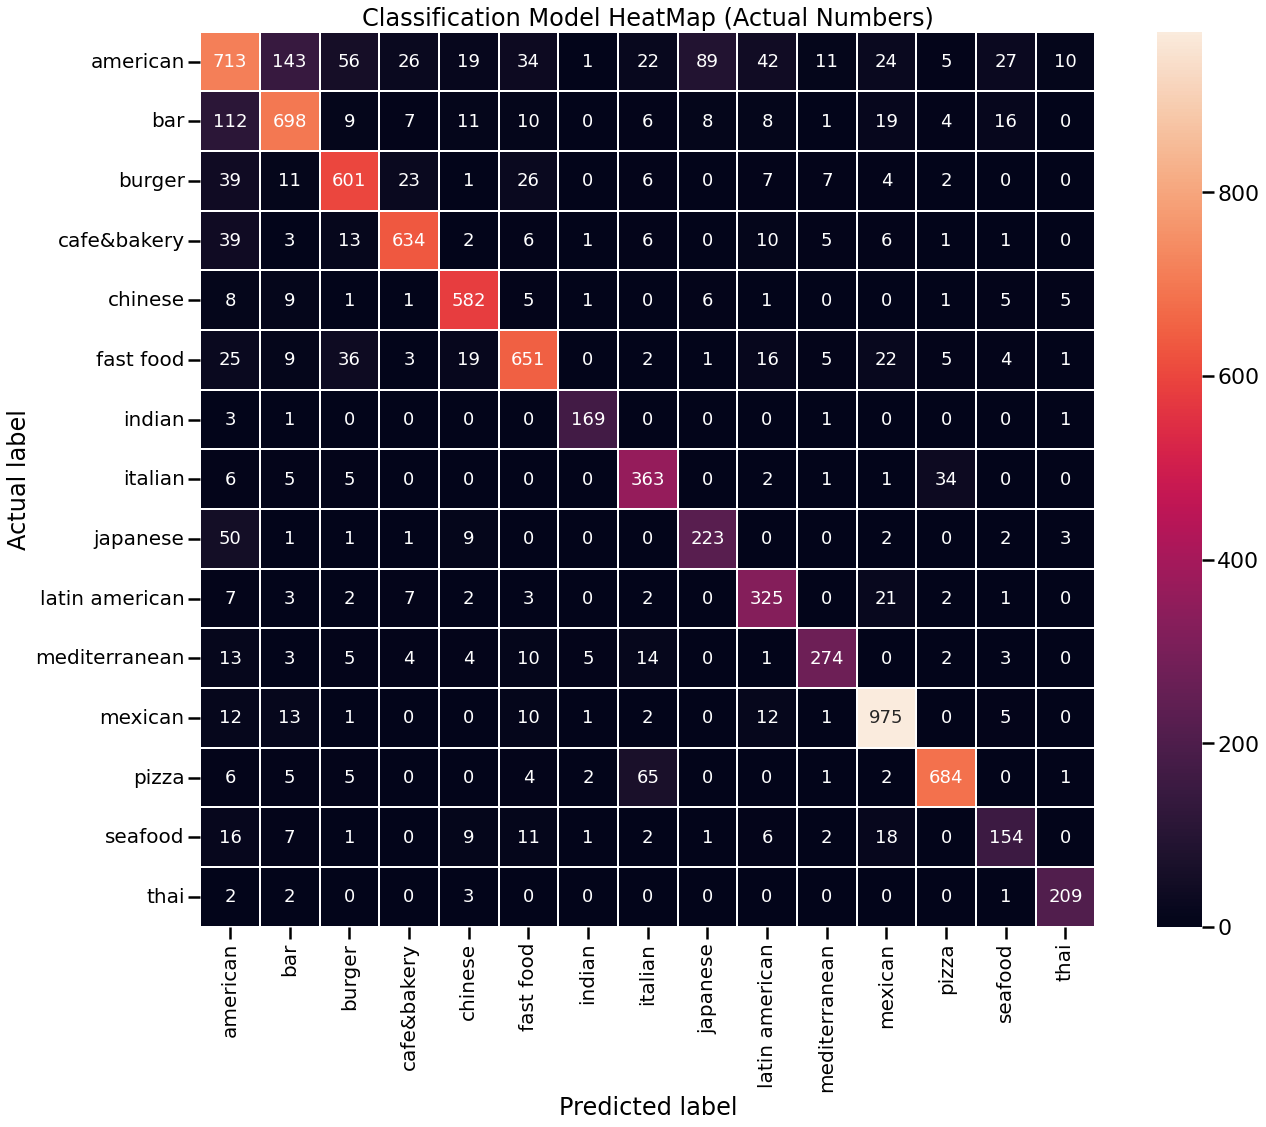

Accuracy: 81.9033641905622


In [26]:
fig = plt.figure(figsize=(20,16))

ax1 =  plot_heatmap_mat(y_tst,y_pred,normalize=False,classes = classes)
ax1.title.set_text('Classification Model HeatMap (Actual Numbers)')

plt.tight_layout()
plt.savefig('../data/output/classification_heatmap_actual_numbers.png',format = 'png')

plt.show()
print('Accuracy: {}'.format(accuracy_score(y_tst,y_pred)*100))

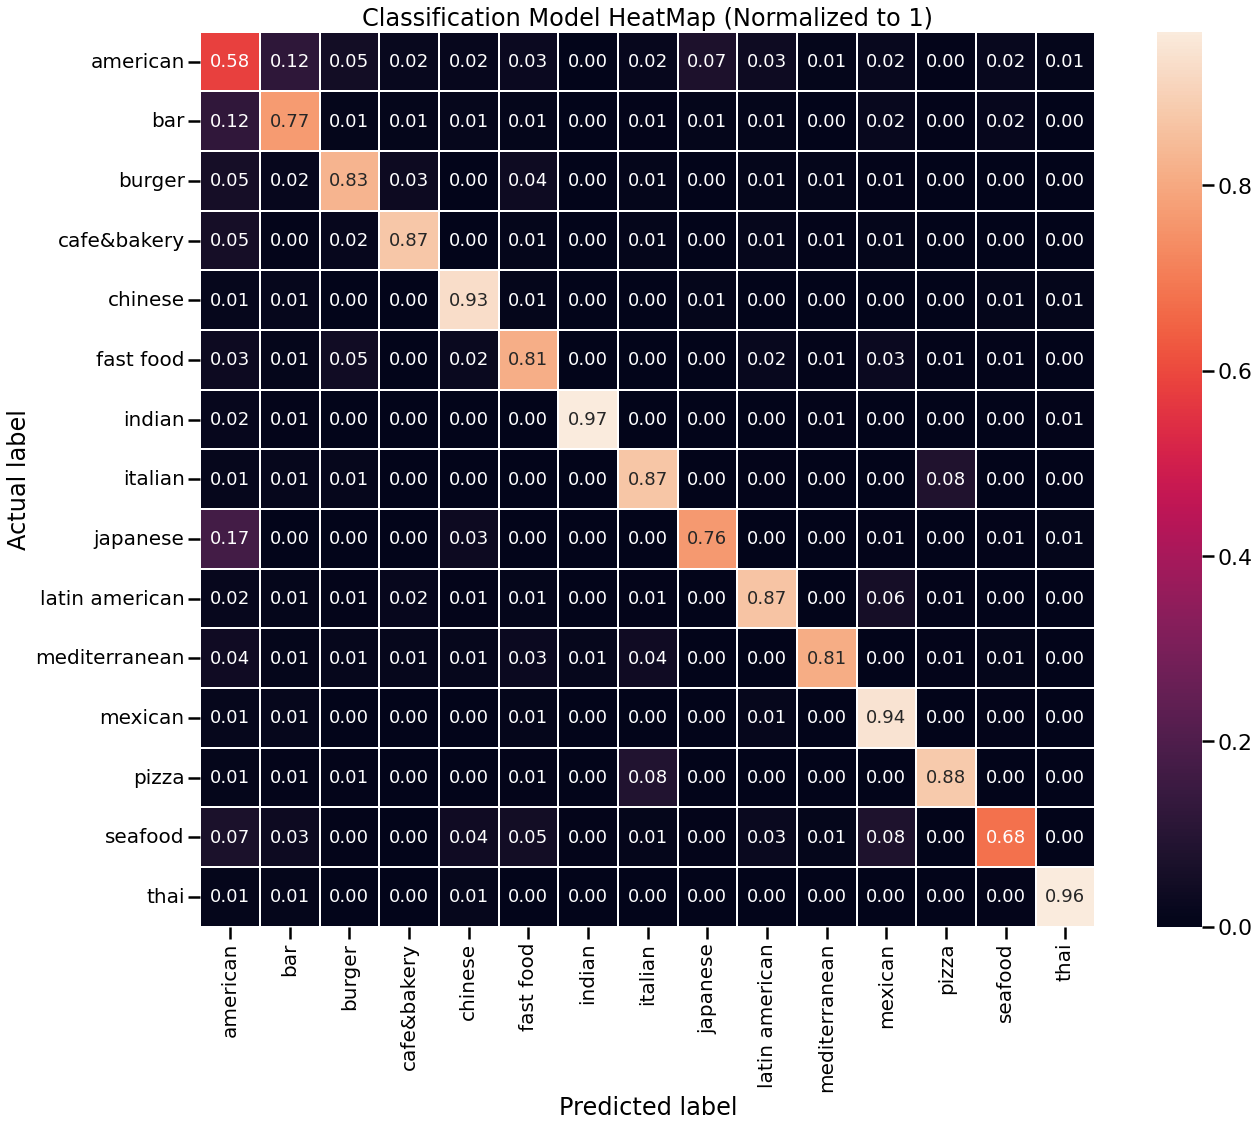

Accuracy: 81.9033641905622


In [27]:
fig = plt.figure(figsize=(20,16))

ax1 =  plot_heatmap_mat(y_tst,y_pred,normalize=True,classes = classes)
ax1.title.set_text('Classification Model HeatMap (Normalized to 1)')

plt.tight_layout()
plt.savefig('../data/output/classification_heatmap_normalized.png',format = 'png')

plt.show()
print('Accuracy: {}'.format(accuracy_score(y_tst,y_pred)*100))